### Inicjalizacja sparka

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Load Hive Table") \
    .enableHiveSupport() \
    .getOrCreate()

24/01/07 22:09:36 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/07 22:09:36 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/07 22:09:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
spark.sparkContext.setLogLevel("ERROR")

#### Wczytanie tabelek

In [7]:
bikes = spark.sql(f"SELECT * FROM bikes where ride_id != 'ride_id'")

In [8]:
bikes_sampled = bikes.sample(withReplacement=False, fraction=0.01, seed=42)

In [9]:
bikes.count()

5817847

In [10]:
bikes.columns

['ride_id',
 'rideable_type',
 'start_time',
 'stop_time',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'start_round_hour',
 'stop_round_hour',
 'partition_year',
 'partition_month']

In [11]:
weather = spark.sql(f"SELECT * FROM weather where name != 'name'")

In [12]:
weather.count()

29303

#### Miesiące a ilość przejazdów

In [13]:
monthly_ride_counts = bikes.groupBy("partition_month", "partition_year") \
                                   .count() \
                                   .orderBy("partition_month")

In [14]:
monthly_ride_counts.show(truncate=False)

+---------------+--------------+------+
|partition_month|partition_year|count |
+---------------+--------------+------+
|01             |2022          |104313|
|01             |2021          |109535|
|02             |2021          |64858 |
|02             |2022          |123133|
|03             |2022          |189149|
|03             |2021          |152777|
|04             |2022          |231696|
|04             |2021          |206413|
|05             |2021          |271841|
|05             |2022          |293623|
|06             |2021          |316713|
|06             |2022          |342610|
|07             |2022          |348765|
|07             |2021          |307050|
|08             |2021          |305873|
|08             |2022          |367048|
|09             |2021          |326474|
|09             |2022          |349864|
|10             |2021          |305753|
|10             |2022          |301488|
+---------------+--------------+------+
only showing top 20 rows



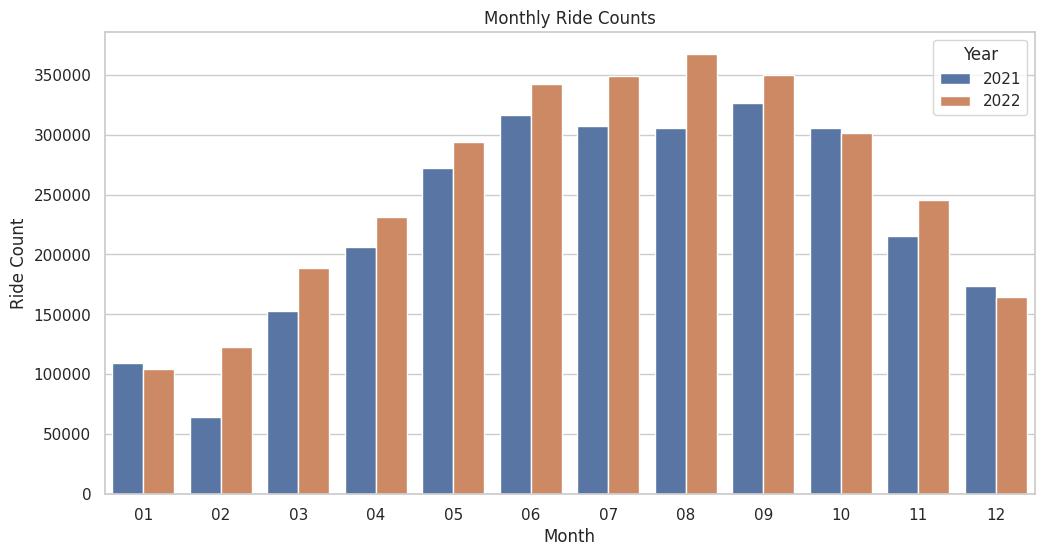

In [15]:
monthly_ride_counts_pd = monthly_ride_counts.toPandas()
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='partition_month', y='count', hue='partition_year', data=monthly_ride_counts_pd)

plt.title('Monthly Ride Counts')
plt.xlabel('Month')
plt.ylabel('Ride Count')

ax.legend(title='Year')

plt.show()

#### Dodanie kolumn borough

In [16]:
boroughs_gdf = gpd.read_file("/home/vagrant/project/borough.geojson")

In [17]:
boroughs_gdf

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1623620725.06,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,1187174784.85,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1,Manhattan,636520830.768,357564.316391,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,1934143372.64,728197.541089,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,3041418506.76,888199.731579,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [18]:
@udf(StringType())
def determine_borough(lat, lng):
    if lat is None or lng is None:
        return None
    
    point = Point(float(lng), float(lat))
    
    
    for idx, row in boroughs_gdf.iterrows():
        if point.within(row['geometry']):
            return row['boro_name']
    return None

In [19]:
bikes_with_boroughs = bikes_sampled.withColumn("start_borough", determine_borough("start_lat", "start_lng")) \
                          .withColumn("end_borough", determine_borough("end_lat", "end_lng"))

#### Dodanie kolumny z godziną, usunięcie nulli i częścią dnia

In [20]:
bikes_with_boroughs = bikes_with_boroughs.withColumn("start_hour", F.hour("start_round_hour"))

In [21]:
bikes_with_boroughs = bikes_with_boroughs.filter(F.col("start_borough").isNotNull())

In [22]:
bikes_with_boroughs.columns

['ride_id',
 'rideable_type',
 'start_time',
 'stop_time',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'start_round_hour',
 'stop_round_hour',
 'partition_year',
 'partition_month',
 'start_borough',
 'end_borough',
 'start_hour']

In [23]:
bikes_day_parts = bikes_with_boroughs.withColumn(
    "time_of_day",
    when((col("start_hour") >= 0) & (col("start_hour") < 6), "early_morning")
    .when((col("start_hour") >= 6) & (col("start_hour") < 12), "morning")
    .when((col("start_hour") >= 12) & (col("start_hour") < 18), "afternoon")
    .otherwise("evening")
)

#### Wyliczenie ilości przejazdów dla każdej dzielnicy w trakcie dnia

In [24]:
borough_hourly_counts = bikes_day_parts.groupBy("start_borough", "start_hour") \
                                           .count() \
                                           .orderBy("start_borough", "start_hour")

In [25]:
borough_hourly_counts = bikes_day_parts.groupBy("start_borough", "time_of_day").count().orderBy("start_borough", "time_of_day")

In [26]:
borough_hourly_counts.show(truncate=False)

+-------------+-------------+-----+
|start_borough|time_of_day  |count|
+-------------+-------------+-----+
|Bronx        |afternoon    |600  |
|Bronx        |early_morning|91   |
|Bronx        |evening      |437  |
|Bronx        |morning      |265  |
|Brooklyn     |afternoon    |5096 |
|Brooklyn     |early_morning|605  |
|Brooklyn     |evening      |3692 |
|Brooklyn     |morning      |3106 |
|Manhattan    |afternoon    |18063|
|Manhattan    |early_morning|1609 |
|Manhattan    |evening      |11450|
|Manhattan    |morning      |10802|
|Queens       |afternoon    |1050 |
|Queens       |early_morning|107  |
|Queens       |evening      |711  |
|Queens       |morning      |683  |
+-------------+-------------+-----+



In [27]:
borough_hourly_pandas = borough_hourly_counts.toPandas()

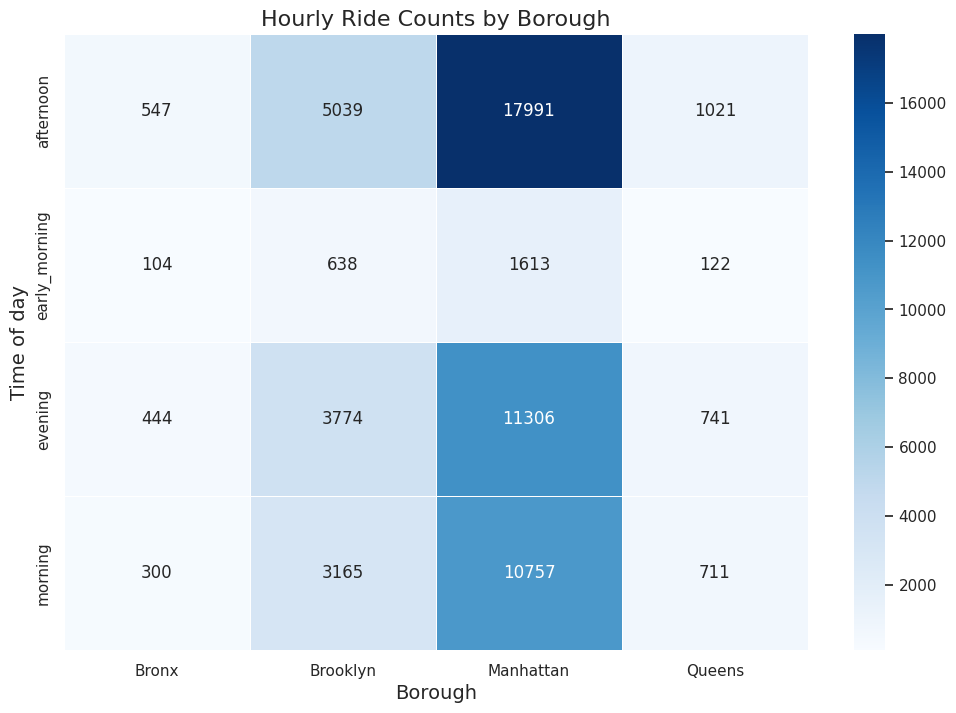

In [28]:
heatmap_data = borough_hourly_pandas.pivot_table(index='time_of_day', columns='start_borough', values='count', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt="d", linewidths=.5)
plt.title('Hourly Ride Counts by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Time of day', fontsize=14)
plt.savefig('times_of_day.png', dpi=300, bbox_inches='tight')
plt.show()

#### Porównanie średniej liczby przejazdów w ciągu tygodnia

In [29]:
bikes_with_date = bikes.withColumn("date", F.to_date("start_round_hour"))

In [30]:
daily_trip_counts = bikes_with_date.groupBy("date").count().orderBy("date")

In [31]:
bikes_with_weekday = daily_trip_counts.withColumn("weekday", F.dayofweek("date"))

In [32]:
average_trips_by_weekday = bikes_with_weekday.groupBy("weekday") \
                                             .agg(F.avg("count").alias("average_trips")) \
                                             .orderBy("weekday")

In [33]:
average_trips_by_weekday = average_trips_by_weekday.withColumn("average_trips", F.round("average_trips", 1))

In [34]:
daily_average_rides = average_trips_by_weekday.withColumn("weekday_name",
                                                            F.when(F.col("weekday") == 1, "Sunday")
                                                            .when(F.col("weekday") == 2, "Monday")
                                                            .when(F.col("weekday") == 3, "Tuesday")
                                                            .when(F.col("weekday") == 4, "Wednesday")
                                                            .when(F.col("weekday") == 5, "Thursday")
                                                            .when(F.col("weekday") == 6, "Friday")
                                                            .when(F.col("weekday") == 7, "Saturday")
                                                            .otherwise("Unknown"))

In [35]:
daily_average_rides.show(truncate=False)

+-------+-------------+------------+
|weekday|average_trips|weekday_name|
+-------+-------------+------------+
|1      |7036.4       |Sunday      |
|2      |7404.4       |Monday      |
|3      |8214.0       |Tuesday     |
|4      |8543.8       |Wednesday   |
|5      |8329.6       |Thursday    |
|6      |8255.7       |Friday      |
|7      |8078.7       |Saturday    |
+-------+-------------+------------+



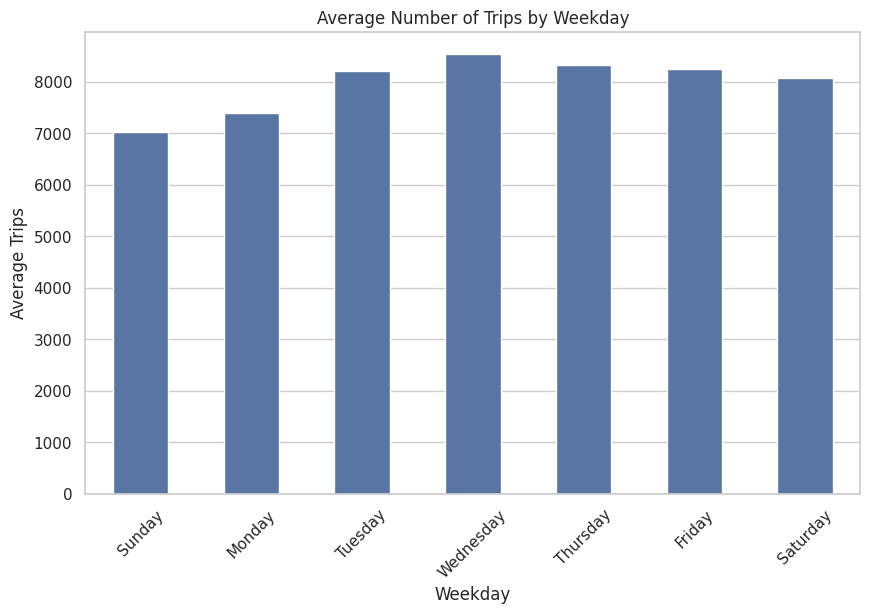

In [36]:
daily_average_rides_pd = daily_average_rides.toPandas()
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday_name', y='average_trips', data=daily_average_rides_pd, width=0.5)

plt.title('Average Number of Trips by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Trips')


plt.xticks(rotation=45)

plt.show()

#### Summer streets 

2021 7.08, 14.08
2022 5, 12, 19.08

In [37]:
bikes_august = bikes_with_date.filter(F.month("start_round_hour") == 8)

In [38]:
average_trips_august = bikes_august.groupBy("date") \
                                             .count() \
                                             .agg(F.avg("count").alias("average_trips"))

In [39]:
average_trips_august.show()

+------------------+
|     average_trips|
+------------------+
|10853.564516129032|
+------------------+



In [40]:
specific_dates = ["2021-08-07", "2021-08-14", "2022-08-05", "2022-08-12", "2022-08-19"]

specific_dates_df = spark.createDataFrame([(date,) for date in specific_dates], ["specific_date"])

rides_count_for_specific_dates = bikes.join(specific_dates_df, on=F.date_format("start_round_hour", "yyyy-MM-dd") == F.col("specific_date"), how="right") \
                                                  .groupBy("specific_date") \
                                                  .count() \
                                                  .orderBy("specific_date")


In [41]:
rides_count_for_specific_dates.show()

+-------------+-----+
|specific_date|count|
+-------------+-----+
|   2021-08-07|11477|
|   2021-08-14|11179|
|   2022-08-05|11805|
|   2022-08-12|12438|
|   2022-08-19|12472|
+-------------+-----+



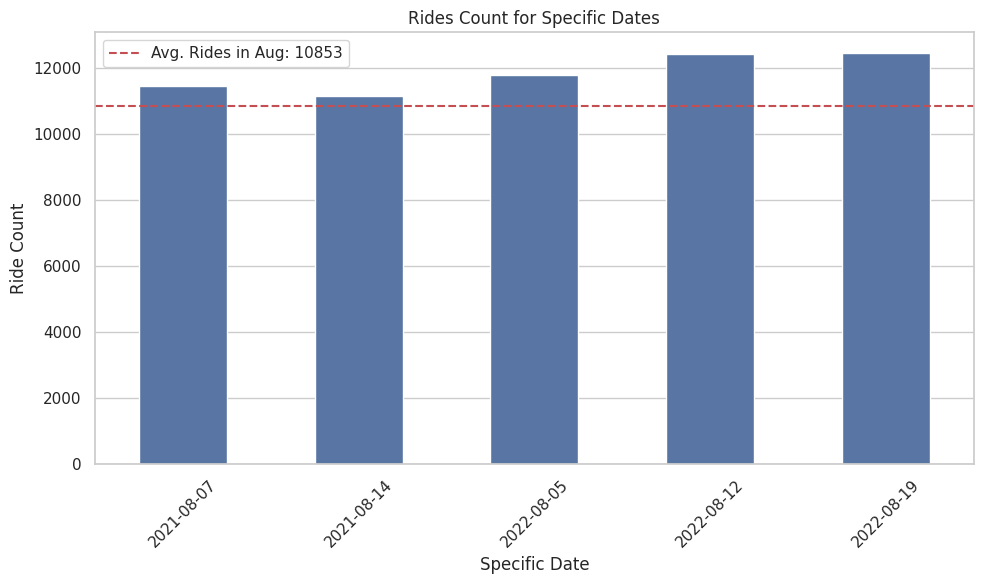

In [42]:
rides_count_for_specific_dates_pd = rides_count_for_specific_dates.toPandas()
average_rides_aug = 10853
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='specific_date', y='count', data=rides_count_for_specific_dates_pd, width=0.5)

plt.axhline(y=average_rides_aug, color='r', linestyle='--', label=f'Avg. Rides in Aug: {average_rides_aug}')

plt.title('Rides Count for Specific Dates')
plt.xlabel('Specific Date')
plt.ylabel('Ride Count')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

In [43]:
plt.savefig('summer_streets.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

#### Długość przejazdu a miesiąc w roku

In [44]:
bikes_trip_duration = bikes.withColumn("trip_duration", 
                                            (F.unix_timestamp("stop_time") - F.unix_timestamp("start_time")) / 60)

In [45]:
average_trip_time_per_month = bikes_trip_duration.groupBy("partition_month", "partition_year") \
                                             .agg(F.avg("trip_duration").alias("avg_trip_duration_minutes")) \
                                             .orderBy("partition_month")

In [46]:
average_trip_time_per_month.show(truncate=False)

+---------------+--------------+-------------------------+
|partition_month|partition_year|avg_trip_duration_minutes|
+---------------+--------------+-------------------------+
|01             |2021          |15.726865385493072       |
|01             |2022          |11.977421638083056       |
|02             |2021          |15.127073247196352       |
|02             |2022          |12.904252989315204       |
|03             |2022          |14.419873045412226       |
|03             |2021          |16.834557775930463       |
|04             |2022          |15.403111548465654       |
|04             |2021          |17.807371386492022       |
|05             |2021          |18.269946463803066       |
|05             |2022          |16.4280851068659         |
|06             |2021          |24.793510107468308       |
|06             |2022          |16.549579697031856       |
|07             |2021          |16.808808608803986       |
|07             |2022          |16.18004883899862       

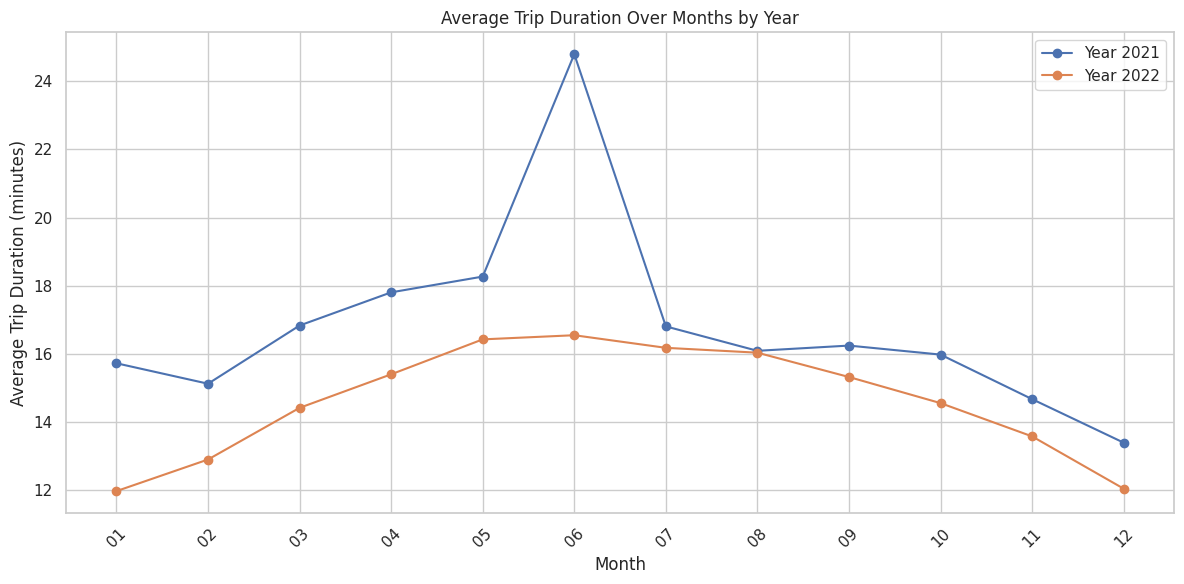

In [47]:
average_trip_time_per_month_pd = average_trip_time_per_month.toPandas()

years = average_trip_time_per_month_pd['partition_year'].unique()

plt.figure(figsize=(12, 6))

for year in years:
    subset_data = average_trip_time_per_month_pd[average_trip_time_per_month_pd['partition_year'] == year]
    plt.plot(subset_data['partition_month'], subset_data['avg_trip_duration_minutes'], marker='o', label=f'Year {year}')

plt.title('Average Trip Duration Over Months by Year')
plt.xlabel('Month')
plt.ylabel('Average Trip Duration (minutes)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

#### Rideable_type

In [48]:
rideable_count_df = bikes.groupBy('rideable_type').count().orderBy('count', ascending=False)
rideable_count_pandas = rideable_count_df.toPandas()

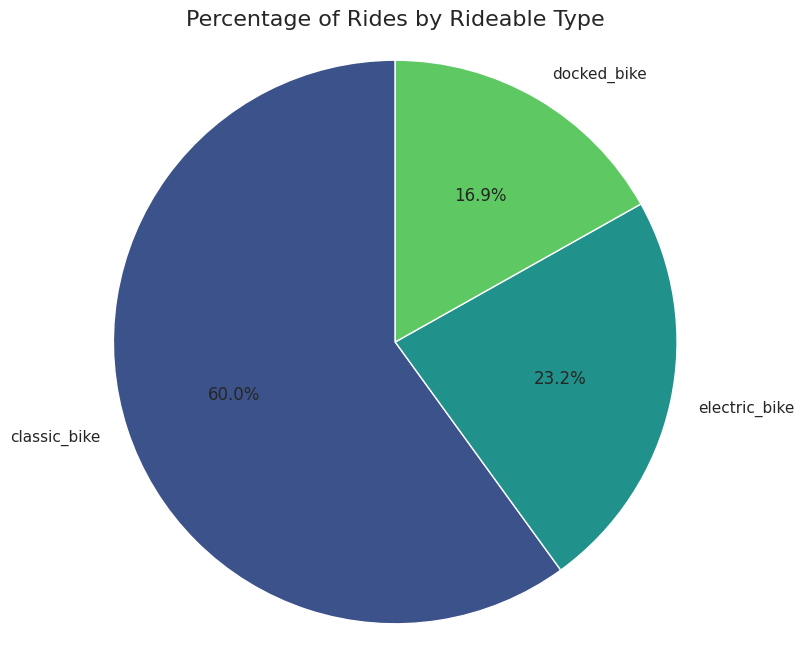

In [49]:
plt.figure(figsize=(8, 8))
plt.pie(rideable_count_pandas['count'], labels=rideable_count_pandas['rideable_type'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(rideable_count_pandas)))
plt.title('Percentage of Rides by Rideable Type', fontsize=16)
plt.axis('equal')
plt.show()